<img width="800px" src="../images/img/001.png"></img>
# NOM DU PROJET: **Application mobile d'aide à la conduite  de reconnaissance des panneau de circulation routiere**
# <!-- TITLE --> Etape2-  Suivi de l'entraînement
<!--Auteur : Tchotaneu Ngatcha Giresse (INSTITUTE FRANCOPHONE INTERNATIONAL) -->

lien de telechargement : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

<!-- DESC --> Episode 4 : Ajout de données par augmentation de données lorsque nous en manquons, pour améliorer nos résultats

## Objectifs :
  - Essayer d'améliorer l'entrainement .
  - Utiliser les **outils d'augmentation des données** de Keras, 


## Ce que nous allons faire :
 - Augmenter et améliorer le jeu de données d'entraînement
 - Identifier les limites de ces outils



In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import os, sys, time, random

from importlib import reload
sys.path.append('..')
import mesFonctionsPersonnelles.fonctionDeBase as projet
run_dir = './run/GTSRB4.001'
datasets_dir = projet.init('GTSRB4', run_dir)

<br>**Projet de reconnaissance de forme**

Version              : 2.0.35
Notebook id          : GTSRB4
Run time             : Wednesday 26 October 2022, 14:38:26
Hostname             : DESKTOP-36O6V1H (Windows)
Tensorflow log level : Info + Warning + Error  (=0)
Datasets dir         : C:\Users\TCHOTANEU\LesProjetsGiresse\datasets
Run dir              : ./run/GTSRB4.001
Update keras cache   : False
tensorflow           : 2.9.1
tensorflow.keras     : 2.9.0
numpy                : 1.23.2
sklearn              : 1.1.2
matplotlib           : 3.5.3
pandas               : 1.4.3


### 1.2 - Paramètres

In [4]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

dataset_name  = 'set-24x24-L'
batch_size    = 64
epochs        = 20
scale         = 1
fit_verbosity = 1


In [5]:
projet.override('enhanced_dir', 'dataset_name', 'batch_size', 'epochs', 'scale', 'fit_verbosity')

## etape 2 - chargement du  dataset

In [8]:
def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset
    Args:
        filename     : datasets filename
        dataset_name : dataset name, without .h5
    Returns:    x_train,y_train, x_test,y_test data, x_meta,y_meta'''
    # ---- Read dataset
    projet.chrono_start()
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]
        x_meta  = f['x_meta'][:]
        y_meta  = f['y_meta'][:]
    print(x_train.shape, y_train.shape)
    # ---- faire le melanger 
    x_train,y_train=projet.shuffle_np_dataset(x_train,y_train)

    # ----
    duration = projet.chrono_stop(hdelay=True)
    size     = projet.hsize(os.path.getsize(filename))
    print(f'Dataset "{dataset_name}" is est charge et est malangé en . ({size} in {duration})')
    return x_train,y_train, x_test,y_test, x_meta,y_meta

# ---- 
#
x_train,y_train,x_test,y_test, x_meta,y_meta = read_dataset(enhanced_dir, dataset_name)

# ---- Rescale 
#
x_train,y_train, x_test,y_test = projet.rescale_dataset(x_train,y_train,x_test,y_test, scale=scale)

(39209, 24, 24, 1) (39209,)
Dataset "set-24x24-L" is est charge et est malangé en . (228.6 Mo in 00:00:00 196ms)


## etape3 - Models


In [9]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Etape 4 - Callbacks  


In [11]:
projet.mkdir(run_dir + '/models')
projet.mkdir(run_dir + '/logs')

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + projet.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Sauvegarde  best model
save_dir = run_dir + "/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Sauvegader model pour chaque  epochs
save_dir = run_dir + "/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir C:\Users\TCHOTANEU\LesProjetsGiresse\Projets\GTSRB\run\GTSRB4.001\logs


## etape 5 - Augementation des donnees avec keras 

In [12]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## Étape 6 - Entraînement du modèle
**Recevoir la forme de mes données :**

In [13]:
(n,lx,ly,lz) = x_train.shape
print("Les images de l'ensemble de données ont la forme suivante : ",(lx,ly,lz))

Les images de l'ensemble de données ont la forme suivante :  (24, 24, 1)


**Récupérer et compiler un modèle, avec la forme des données :**

In [14]:
model = get_model_v1(lx,ly,lz)

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 22, 96)        960       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 192)         166080    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 192)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 192)         0

## **Entraînement:**

In [15]:
projet.chrono_start()

history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.h5')

projet.chrono_show()

Epoch 1/20
612/612 [==============================] - 64s 104ms/step - loss: 2.1663 - accuracy: 0.3981 - val_loss: 0.8096 - val_accuracy: 0.7717
Epoch 2/20
612/612 [==============================] - 60s 99ms/step - loss: 0.9103 - accuracy: 0.7226 - val_loss: 0.4733 - val_accuracy: 0.8672
Epoch 3/20
612/612 [==============================] - 60s 98ms/step - loss: 0.6017 - accuracy: 0.8166 - val_loss: 0.3072 - val_accuracy: 0.9097
Epoch 4/20
612/612 [==============================] - 64s 104ms/step - loss: 0.4547 - accuracy: 0.8587 - val_loss: 0.2576 - val_accuracy: 0.9257
Epoch 5/20
612/612 [==============================] - 63s 104ms/step - loss: 0.3645 - accuracy: 0.8878 - val_loss: 0.2296 - val_accuracy: 0.9378
Epoch 6/20
612/612 [==============================] - 64s 105ms/step - loss: 0.3052 - accuracy: 0.9044 - val_loss: 0.1912 - val_accuracy: 0.9454
Epoch 7/20
612/612 [==============================] - 64s 105ms/step - loss: 0.2576 - accuracy: 0.9196 - val_loss: 0.1808 - val_accu

## **Evaluation :**

In [16]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9675


In [17]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test de perte       : {:5.4f}'.format(score[0]))
print('Test de accuracy  : {:5.4f}'.format(score[1]))

Test de perte       : 0.1688
Test de accuracy  : 0.9634


## Étape 7 - Historique

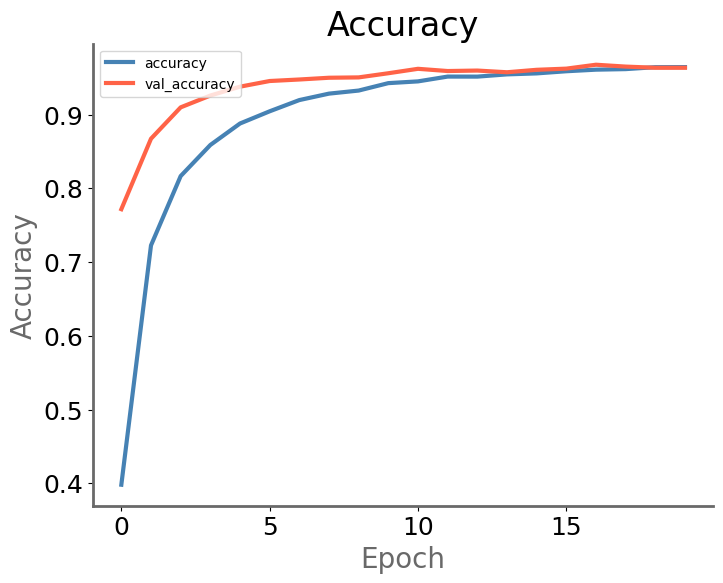

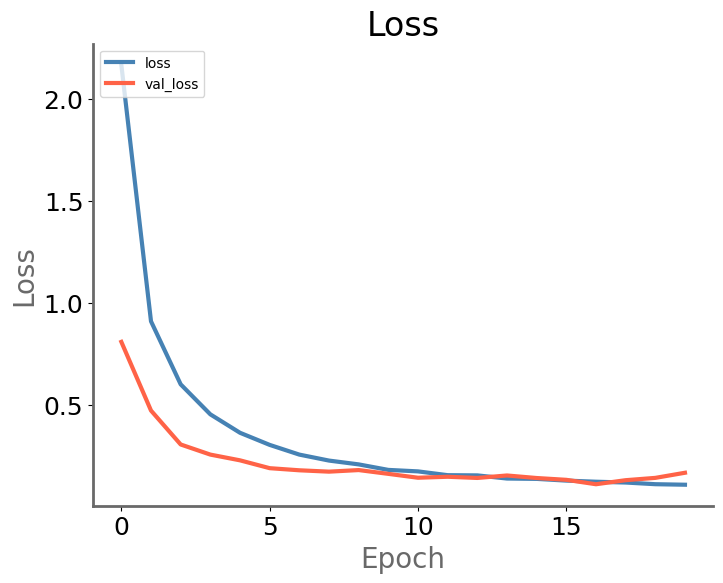

In [18]:
projet.plot_history(history, save_as='01-history')

## Step 8 - Evaluate best model

### 8.1 - Recuperer le meilleur modèle :

In [20]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.h5')
#best_model.summary()
print("Loaded.")

Loaded.


### 8.2 - l"evaluation :

In [21]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test de perte      : {:5.4f}'.format(score[0]))
print('Test de accuracy : {:5.4f}'.format(score[1]))

Test de perte      : 0.1688
Test de accuracy : 0.9634


**Plot confusion matrix**

395/395 [==============================] - 5s 13ms/step


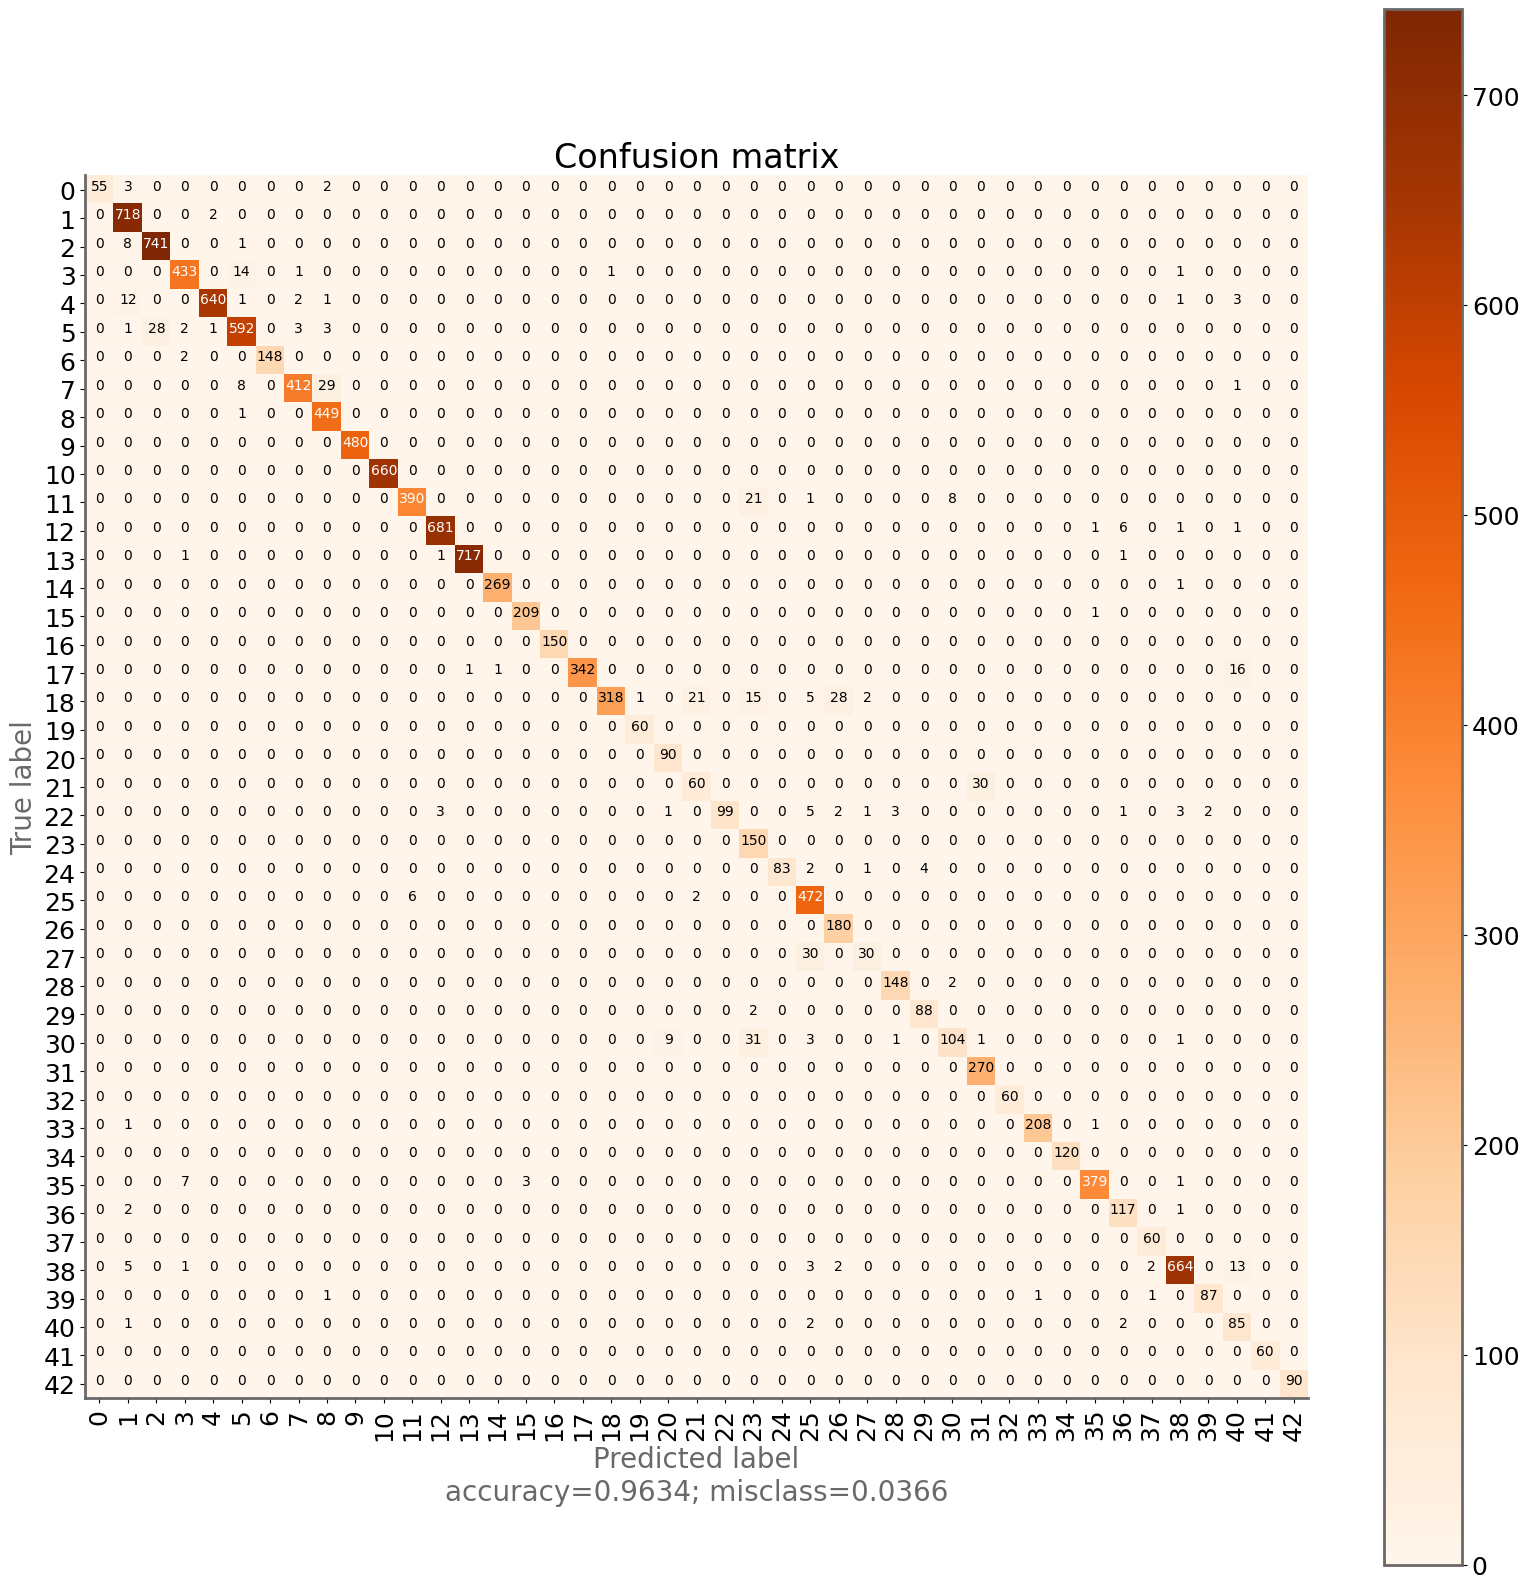

In [22]:
y_sigmoid = model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

cmap = plt.get_cmap('Oranges')
projet.plot_confusion_matrix(y_test,y_pred,range(43), figsize=(16, 16),normalize=False, cmap=cmap, save_as='02-confusion-matrix')

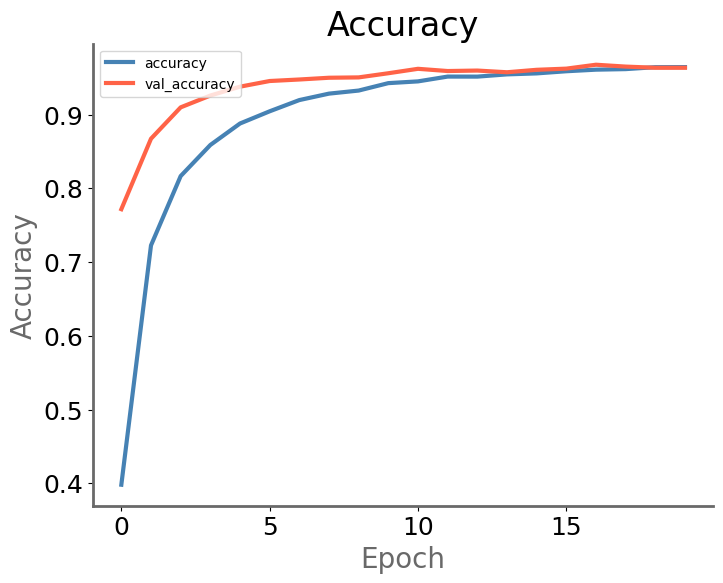

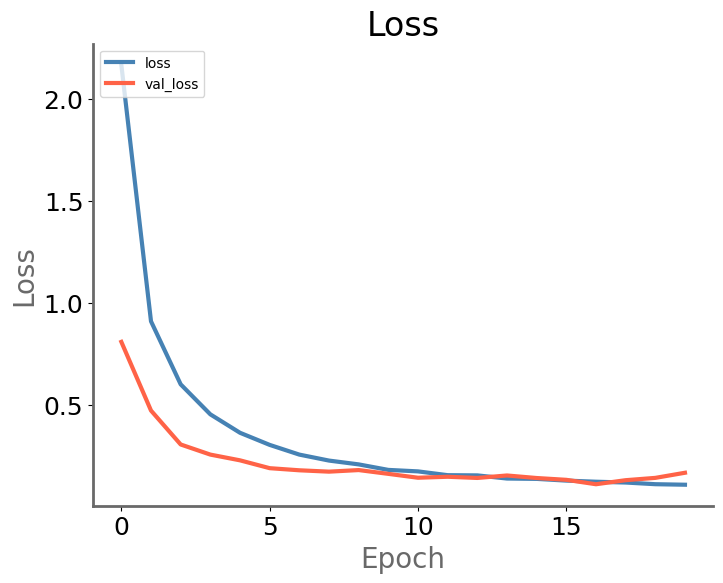

In [23]:
projet.plot_history(history, save_as='04-history')

In [24]:
projet.end()

**Fin du traitement :** Wednesday 26 October 2022, 15:46:56  
**Durée :** 01:08:30 858ms  
Notre notebook se termine ici ,le code est disponible sur  :-)  
[https://github.com/tchotaneu](https://github.com/tchotaneu)